In [1]:
import argparse
import os
import csv
import random
import time
import json
import math
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## Load data

In [2]:
training_traj = np.load(f'/root/Calibration/PhyPhox/Data/training_traj_0.6.npy')
validation_traj = np.load(f'./all_User_data.npy', allow_pickle=True)

In [3]:
posture_data = defaultdict(list)

valid_data = validation_traj.item()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            data = valid_data[user_name][path_name][posture_name]
            pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
            mag = data[:, [12, 13, 14]]

            pos_mag = np.concatenate((pos, mag), axis=-1)
            posture_data[posture_name].append(pos_mag)

In [4]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [5]:
prep_training_traj = split_traj(training_traj)
prep_valid_front_pocket_traj = split_traj(posture_data['front_pocket'])
prep_valid_horizontal_traj = split_traj(posture_data['horizontal'])
prep_valid_pocket_traj = split_traj(posture_data['pocket'])
prep_valid_swing_traj = split_traj(posture_data['swing'])
prep_valid_target_traj = split_traj(posture_data['target'])

In [6]:
def expand_seq_features(seq):
    ### neighbors
    s_cord = seq[:, :, 0:2]
    s_mag = seq[:, :, 2:5]
    
    s_magT = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2) + np.power(s_mag[:, :, 2:3], 2))
    s_magH = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2))  # magH
    s_elevation_angle = np.arccos(s_magH / s_magT) / np.pi * 180  # angle
    # n_azimuth_angle = 0
    
    print(s_cord.shape, s_mag.shape, s_magT.shape, s_magH.shape, s_elevation_angle.shape)
    s_new = np.concatenate([s_cord, s_mag, s_magT, s_magH, s_elevation_angle], axis=-1)
    
    return s_new

In [7]:
prep_training_traj = expand_seq_features(prep_training_traj)
prep_valid_front_pocket_traj = expand_seq_features(prep_valid_front_pocket_traj)
prep_valid_horizontal_traj = expand_seq_features(prep_valid_horizontal_traj)
prep_valid_pocket_traj = expand_seq_features(prep_valid_pocket_traj)
prep_valid_swing_traj = expand_seq_features(prep_valid_swing_traj)
prep_valid_target_traj = expand_seq_features(prep_valid_target_traj)

(31000, 20, 2) (31000, 20, 3) (31000, 20, 1) (31000, 20, 1) (31000, 20, 1)
(123, 20, 2) (123, 20, 3) (123, 20, 1) (123, 20, 1) (123, 20, 1)
(123, 20, 2) (123, 20, 3) (123, 20, 1) (123, 20, 1) (123, 20, 1)
(123, 20, 2) (123, 20, 3) (123, 20, 1) (123, 20, 1) (123, 20, 1)
(123, 20, 2) (123, 20, 3) (123, 20, 1) (123, 20, 1) (123, 20, 1)
(123, 20, 2) (123, 20, 3) (123, 20, 1) (123, 20, 1) (123, 20, 1)


In [8]:
prep_training_traj.shape, prep_valid_front_pocket_traj.shape, prep_valid_horizontal_traj.shape, prep_valid_pocket_traj.shape, prep_valid_swing_traj.shape, prep_valid_target_traj.shape

((31000, 20, 8),
 (123, 20, 8),
 (123, 20, 8),
 (123, 20, 8),
 (123, 20, 8),
 (123, 20, 8))

## Create Dataset & Dataloader

In [9]:
class SequenceDataset(Dataset):
    def __init__(self, sequence, pos):
        self.sequence = sequence
        self.pos = pos

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        return self.sequence[idx], self.pos[idx]

In [10]:
### train dataloader ###
train_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_training_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_training_traj[:, -1, :2], dtype=torch.float)
                )
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


### test dataloader ###
front_pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_front_pocket_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_front_pocket_traj[:, -1, :2], dtype=torch.float)
                )
front_pocket_loader = DataLoader(front_pocket_dataset, batch_size=32)

horizontal_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_horizontal_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_horizontal_traj[:, -1, :2], dtype=torch.float)
                )
horizontal_loader = DataLoader(horizontal_dataset, batch_size=32)

pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_pocket_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_pocket_traj[:, -1, :2], dtype=torch.float)
                )
pocket_loader = DataLoader(pocket_dataset, batch_size=32)

swing_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_swing_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_swing_traj[:, -1, :2], dtype=torch.float)
                )
swing_loader = DataLoader(swing_dataset, batch_size=32)

target_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_target_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_target_traj[:, -1, :2], dtype=torch.float)
                )
target_loader = DataLoader(target_dataset, batch_size=32)

## Model

In [11]:
class Locator(nn.Module):
    def __init__(self, seq_len=60):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=6, hidden_size=32, num_layers=3, batch_first=True, bidirectional=False)
        
        self.last = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 2),
        )
        
    def forward(self, features):
        h, _ = self.lstm(features)
        
        pos = self.last(h[:, -1])
        
        return pos

In [12]:
def train(dataloader):
    model.train()

    mse_loss = []
    l1_loss = []

    for sequences, gt_pos in dataloader:
        optimizer.zero_grad()
        
        sequences = sequences.to(device)
        gt_pos = gt_pos.to(device)
        
        # localization
        pred_pos = model(sequences)
        
        # loss
        loss = MSE_Loss(pred_pos, gt_pos)
        
        # backward
        loss.backward()
        optimizer.step()
        
        # record loss
        mse_loss.append(loss.item())
        l1_loss.append(L1_loss(pred_pos, gt_pos).item())
    
    return np.mean(mse_loss), np.mean(l1_loss)

In [13]:
def evaluate(dataloader):
    model.eval()

    mse_loss = []
    l1_loss = []

    with torch.no_grad():
        for sequences, gt_pos in dataloader:
            optimizer.zero_grad()
            
            sequences = sequences.to(device)
            gt_pos = gt_pos.to(device)

            # localization
            pred_pos = model(sequences)

            # loss
            loss = MSE_Loss(pred_pos, gt_pos)

            # record loss
            mse_loss.append(loss.item())
            l1_loss.append(L1_loss(pred_pos, gt_pos).item())
    
    return np.mean(mse_loss), np.mean(l1_loss)

In [14]:
EPOCH = 1000
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
MSE_Loss = torch.nn.MSELoss()
L1_loss = torch.nn.L1Loss()

In [15]:
model = Locator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [16]:
from torchinfo import summary
summary(model, input_size=[(1, 20, 6)])

Layer (type:depth-idx)                   Output Shape              Param #
Locator                                  [1, 2]                    --
├─LSTM: 1-1                              [1, 20, 32]               22,016
├─Sequential: 1-2                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 16]                   528
│    └─LeakyReLU: 2-2                    [1, 16]                   --
│    └─Linear: 2-3                       [1, 8]                    136
│    └─LeakyReLU: 2-4                    [1, 8]                    --
│    └─Linear: 2-5                       [1, 2]                    18
Total params: 22,698
Trainable params: 22,698
Non-trainable params: 0
Total mult-adds (M): 0.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated Total Size (MB): 0.10

In [ ]:
for epoch in range(EPOCH):
    
    train_loss, train_l1 = train(train_loader)
    front_pocket_loss, front_pocket_l1 = evaluate(front_pocket_loader)
    horizontal_loss, horizontal_l1 = evaluate(horizontal_loader)
    pocket_loss, pocket_l1 = evaluate(pocket_loader)
    swing_loss, swing_l1 = evaluate(swing_loader)
    target_loss, target_l1 = evaluate(target_loader)
    
    if (epoch + 1) % 1 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep:>5}: train mse loss: {train_loss: >6.3f}, l1 loss: {train_l1: >6.3f}     horizontal mse loss: {horizontal_loss: >6.3f}, l1 loss: {horizontal_l1: >6.3f}   target mse loss: {target_loss: >6.3f}, l1 loss: {target_l1: >6.3f}')
        print(f'       swing mse loss: {swing_loss: >6.3f}, l1 loss: {swing_l1: >6.3f}   front_pocket mse loss: {front_pocket_loss: >6.3f}, l1 loss: {front_pocket_l1: >6.3f}   pocket mse loss: {pocket_loss: >6.3f}, l1 loss: {pocket_l1: >6.3f}')

```text
01000: train mse loss:  0.001, l1 loss:  0.021     horizontal mse loss:  6.739, l1 loss:  2.113   target mse loss:  3.329, l1 loss:  1.399
       swing mse loss:  6.526, l1 loss:  2.105   front_pocket mse loss:  6.135, l1 loss:  2.135   pocket mse loss:  5.870, l1 loss:  1.985
       
01000: train mse loss:  0.000, l1 loss:  0.004     horizontal mse loss:  5.941, l1 loss:  1.969   target mse loss:  3.925, l1 loss:  1.654
       swing mse loss:  4.651, l1 loss:  1.780   front_pocket mse loss:  5.609, l1 loss:  1.971   pocket mse loss:  5.016, l1 loss:  1.817
```

In [ ]:
# torch.save({
#     'locator_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     }, f'/root/Mag/Experiments/0712/loc/m_A_gpr_model.pt')

In [18]:
def pred_sequence_pos(dataloader):
    model.eval()

    pred_poses = []
    gt_poses = []

    with torch.no_grad():
        for sequences, gt_pos in dataloader:
            optimizer.zero_grad()
            
            sequences = sequences.to(device)
            gt_pos = gt_pos.to(device)

            # localization
            pred_pos = model(sequences)

            gt_poses.extend(gt_pos.detach().cpu().numpy())
            pred_poses.extend(pred_pos.detach().cpu().numpy())
    
    return np.array(gt_poses), np.array(pred_poses)

In [48]:
# # gt pos need save all points

# gt_poses, pred_poses = pred_sequence_pos(train_loader)
# print(gt_poses.shape, pred_poses.shape, prep_training_traj.shape)

# test_seq = prep_training_traj[::5000, :, :2]

# plt.figure()

# plt.plot(test_seq[:, :, 1].T, test_seq[:, :, 0].T, alpha=0.25)

# plt.scatter(test_seq[:, -1, 1], test_seq[:, -1, 0])
# plt.scatter(gt_poses[::5000, 1], gt_poses[::5000, 0])
# plt.scatter(pred_poses[::5000, 1], pred_poses[::5000, 0])

# plt.axis('equal')
# plt.gca().invert_yaxis()
# plt.show()

(123, 2) (123, 2) (123, 20, 8)


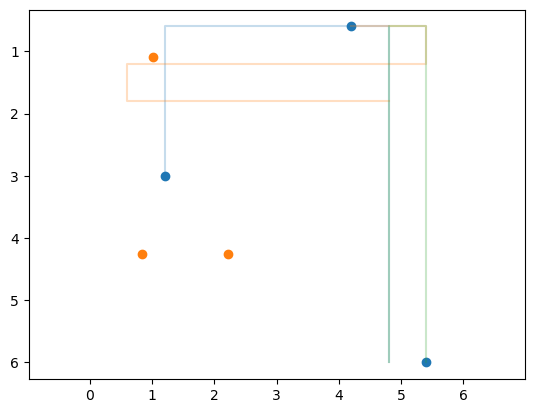

In [37]:
gt_poses, pred_poses = pred_sequence_pos(target_loader)
print(gt_poses.shape, pred_poses.shape, prep_training_traj.shape)

test_seq = prep_training_traj[::50, :, :2]

plt.figure()

plt.plot(test_seq[:, :, 1].T, test_seq[:, :, 0].T, alpha=0.25)

plt.scatter(test_seq[:, -1, 1], test_seq[:, -1, 0])
plt.scatter(pred_poses[::50, 1], pred_poses[::50, 0])

plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()

(123, 2) (123, 2) (123, 20, 8)


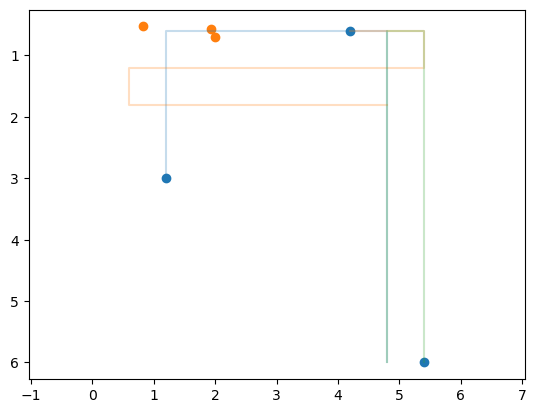

In [38]:
gt_poses, pred_poses = pred_sequence_pos(horizontal_loader)
print(gt_poses.shape, pred_poses.shape, prep_valid_horizontal_traj.shape)

test_seq = prep_valid_horizontal_traj[::50, :, :2]

plt.figure()

plt.plot(test_seq[:, :, 1].T, test_seq[:, :, 0].T, alpha=0.25)

plt.scatter(test_seq[:, -1, 1], test_seq[:, -1, 0])
plt.scatter(pred_poses[::50, 1], pred_poses[::50, 0])

plt.axis('equal')
plt.gca().invert_yaxis()
plt.show()